In [299]:
# 导入程序所需要的程序包

#抓取网页内容用的程序包
import json
import requests

#PyTorch用的包
import torch
import torch.nn as nn
import torch.optim
#from torch.autograd import Variable

# 自然语言处理相关的包
import re #正则表达式的包
import jieba #结巴分词包
from collections import Counter #搜集器，可以让统计词频更简单

#绘图、计算用的程序包
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [328]:
# 数据来源文件
good_file = './dataset/data_haotian/中国寓言故事.txt'
bad_file  = './dataset/data_haotian/外国民间故事.txt'
#is_filter = True
# 将文本中的标点符号过滤掉
def filter_punc(sentence):
    sentence = re.sub("[\s+\.\!\/_,$%^*(+\"\'“”《》?“]+|[+——！，。？、~@#￥%……&*（）：]+", "", sentence)  
    return(sentence)

In [327]:
#扫描所有的文本，分词、建立词典，分出正向还是负向的评论
#def Prepare_data(good_file, bad_file, is_filter = True):
all_words = [] #存储所有的单词
pos_sentences = [] #存储正向的评论
# 统计bad file的行数和单词数
with open(good_file, 'r') as fr:
    for idx, line in enumerate(fr): # idx 是编号 line 是一段评论文本

        #过滤标点符号
        line = filter_punc(line)
        #分词
        words = jieba.lcut(line)
        #print(words)
        if len(words) > 0:
            all_words += words
            pos_sentences.append(words)
print('{0} 包含 {1} 行, {2} 个词.'.format(good_file, idx+1, len(all_words)))

./dataset/data_haotian/中国寓言故事.txt 包含 2210 行, 287512 个词.


In [329]:
# 统计bad file的行数和单词数
neg_sentences = [] #存储负向的评论
count = len(all_words)
with open(bad_file, 'r') as fr:
    for idx, line in enumerate(fr):
        #if is_filter:
        line = filter_punc(line)
        words = jieba.lcut(line)
        if len(words) > 0:
            all_words += words
            neg_sentences.append(words)
print('{0} 包含 {1} 行, {2} 个词.'.format(bad_file, idx+1, len(all_words)-count))

./dataset/data_haotian/外国民间故事.txt 包含 1779 行, 294394 个词.


In [330]:

#建立词典，diction的每一项为{w:[id, 单词出现次数]}
diction = {}
cnt = Counter(all_words) #counter作用就是在一个数组内，遍历所有元素，将元素出现的次数记下来
for word, freq in cnt.items():
    diction[word] = [len(diction), freq] #用len(diction) 是作为词语的编号
print('字典大小：{}'.format(len(diction)))

#return(pos_sentences, neg_sentences, diction)

字典大小：46428


In [331]:
#diction

In [332]:

#pos_sentences, neg_sentences, diction = Prepare_data(good_file, bad_file, True)
#根据词频对diction进行排序，左边是词频，右边是词语
st = sorted([(v[1], w) for w, v in diction.items()]) 
#st

In [333]:

#根据单词返还单词的编码
def word2index(word, diction):
    if word in diction:
        value = diction[word][0]
    else:
        value = -1
    return(value)

#根据编码获得单词
def index2word(index, diction):
    for w,v in diction.items():
        if v[0] == index:
            return(w)
    return(None)



In [334]:
# 输入一个句子和相应的词典，得到这个句子的向量化表示
# 向量的尺寸为词典中词汇的个数，i位置上面的数值为第i个单词在sentence中出现的频率
def sentence2vec(sentence, dictionary):
    #zeros(shape, dtype=float, order='C')返回一个给定形状和类型的用0填充的数组
    vector = np.zeros(len(dictionary)) 
    #print(vector)
    for l in sentence:
        vector[l] += 1
    result = (1.0 * vector / len(sentence)) #计算单词在sentence中出现的频率
    return result



In [335]:
# 遍历所有句子，将每一个词映射成编码
dataset = [] #数据集
labels = [] #标签
sentences = [] #原始句子，调试用
# 处理正向评论 （分词和去标点后的正向评论）
for sentence in pos_sentences:
    new_sentence = []
    for l in sentence:
        #l是每个词
        if l in diction:
            new_sentence.append(word2index(l, diction)) # 每个new_sentence都是句子中每个词语的编号（不是词频）
    dataset.append(sentence2vec(new_sentence, diction)) #sentence2vec将句子转化为词频表示的向量
    labels.append(0) #正标签为0
    sentences.append(sentence)


In [336]:

# 处理负向评论
for sentence in neg_sentences:
    new_sentence = []
    for l in sentence:
        if l in diction:
            new_sentence.append(word2index(l, diction))
    dataset.append(sentence2vec(new_sentence, diction))
    labels.append(1) #负标签为1
    sentences.append(sentence)

In [337]:


#打乱所有的数据顺序，形成数据集
# indices为所有数据下标的一个全排列
indices = np.random.permutation(len(dataset))
indices

array([ 813, 1967,  268, ..., 1976,  712,  108])

In [338]:

#重新根据打乱的下标生成数据集dataset，标签集labels，以及对应的原始句子sentences
dataset = [dataset[i] for i in indices]
labels = [labels[i] for i in indices]
sentences = [sentences[i] for i in indices]

In [339]:
#对整个数据集进行划分，分为：训练集、校准集和测试集，其中校准和测试集合的长度都是整个数据集的10分之一
test_size = len(dataset) // 10
train_data = dataset[2 * test_size :]
train_label = labels[2 * test_size :]

valid_data = dataset[: test_size]
valid_label = labels[: test_size]

test_data = dataset[test_size : 2 * test_size]
test_label = labels[test_size : 2 * test_size]

# 模型

In [340]:
def rightness(predictions, labels):
    """计算预测错误率的函数，其中predictions是模型给出的一组预测结果，
    batch_size行num_classes列的矩阵，labels是数据之中的正确答案"""
    pred = torch.max(predictions.data, 1)[1] # 对于任意一行（一个样本）的输出值的第1个维度，求最大，得到每一行的最大元素的下标
    rights = pred.eq(labels.data.view_as(pred)).sum() #将下标与labels中包含的类别进行比较，并累计得到比较正确的数量
    return rights, len(labels) #返回正确的数量和这一次一共比较了多少元素

In [341]:
# 一个简单的前馈神经网络，三层，第一层线性层，加一个非线性ReLU，第二层线性层，中间有10个隐含层神经元

# 输入维度为词典的大小：每一段评论的词袋模型
model = nn.Sequential(
    nn.Linear(len(diction), 10),
    nn.ReLU(),
    nn.Linear(10, 2),
    nn.LogSoftmax(),
)


# 交叉熵损失函数 (Cross-entropy loss function)

交叉熵损失函数的标准形式如下:

 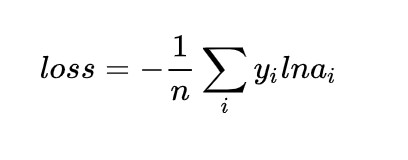

注意公式中 x 表示样本， y 表示实际的标签， a 表示预测的输出， n 表示样本总数量。

特点：

(1)本质上也是一种对数似然函数，可用于二分类和多分类任务中。

二分类问题中的loss函数（输入数据是softmax或者sigmoid函数的输出）：

 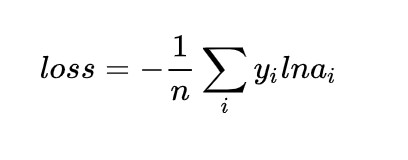

多分类问题中的loss函数（输入数据是softmax或者sigmoid函数的输出）：

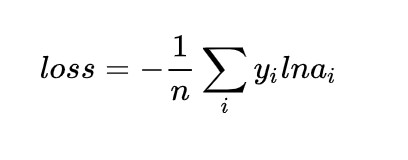[公式]

(2)当使用sigmoid作为激活函数的时候，常用交叉熵损失函数而不用均方误差损失函数，因为它可以完美解决平方损失函数权重更新过慢的问题，具有“误差大的时候，权重更新快；误差小的时候，权重更新慢”的良好性质。


这里需要更正一点，对数损失函数和交叉熵损失函数应该是等价的！！！

In [342]:
'''import numpy as np
def cross_entropy(Y, P):
    """Cross-Entropy loss function.
    以向量化的方式实现交叉熵函数
    Y and P are lists of labels and estimations
    returns the float corresponding to their cross-entropy.
    """
    Y = np.float_(Y)
    P = np.float_(P)
    return -np.sum(Y * np.log(P) + (1 - Y) * np.log(1 - P)) / len(Y)'''

'import numpy as np\ndef cross_entropy(Y, P):\n    """Cross-Entropy loss function.\n    以向量化的方式实现交叉熵函数\n    Y and P are lists of labels and estimations\n    returns the float corresponding to their cross-entropy.\n    """\n    Y = np.float_(Y)\n    P = np.float_(P)\n    return -np.sum(Y * np.log(P) + (1 - Y) * np.log(1 - P)) / len(Y)'

In [343]:
# 损失函数为交叉熵
cost = torch.nn.NLLLoss()
# 优化算法为Adam，可以自动调节学习率
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
'''
params (iterable):待优化参数的iterable或者是定义了参数组的dict
lr： (float, 可选) – 学习率（默认：1e-3）
同样也称为学习率或步长因子，它控制了权重的更新比率（如 0.001）。
较大的值（如 0.3）在学习率更新前会有更快的初始学习，
而较小的值（如 1.0E-5）会令训练收敛到更好的性能
'''

'\nparams (iterable):待优化参数的iterable或者是定义了参数组的dict\nlr： (float, 可选) – 学习率（默认：1e-3）\n同样也称为学习率或步长因子，它控制了权重的更新比率（如 0.001）。\n较大的值（如 0.3）在学习率更新前会有更快的初始学习，\n而较小的值（如 1.0E-5）会令训练收敛到更好的性能\n'

In [344]:

records = []
losses = []
#循环5个Epoch
for epoch in range(5):
    for i, data in enumerate(zip(train_data, train_label)):
        x, y = data
        # 需要将输入的数据进行适当的变形，主要是要多出一个batch_size的维度，一维
        x = torch.tensor(x, requires_grad = True, dtype = torch.float).view(1,-1)
        # x的尺寸：batch_size=1, len_dictionary
        
        # 标签也要加一层外衣以变成1*1的张量
        y = torch.tensor(np.array([y]), dtype = torch.long)
        # y的尺寸：batch_size=1, 1
        
        # 清空梯度
        optimizer.zero_grad()
        # 模型预测
        predict = model(x)
        # 计算损失函数
        loss = cost(predict, y)
        # 将损失函数数值加入到列表中
        losses.append(loss.data.numpy())
        # 开始进行梯度反传
        loss.backward()
        # 开始对参数进行一步优化
        optimizer.step()
        
        # 每隔3000步，跑一下校验数据集的数据，输出临时结果
        if i % 3000 == 0:
            val_losses = []
            rights = []
            # 在所有校验数据集上实验
            for j, val in enumerate(zip(valid_data, valid_label)):
                x, y = val
                x = torch.tensor(x, requires_grad = True, dtype = torch.float).view(1,-1)
                y = torch.tensor(np.array([y]), dtype = torch.long)
                predict = model(x)
                # 调用rightness函数计算准确度
                right = rightness(predict, y)
                rights.append(right)
                loss = cost(predict, y)
                val_losses.append(loss.data.numpy())
                
            # 将校验集合上面的平均准确度计算出来
            right_ratio = 1.0 * np.sum([i[0] for i in rights]) / np.sum([i[1] for i in rights])
            print('第{}轮，训练损失：{:.2f}, 校验损失：{:.2f}, 校验准确率: {:.2f}'.format(epoch, np.mean(losses),
                                                                        np.mean(val_losses), right_ratio))
            records.append([np.mean(losses), np.mean(val_losses), right_ratio])

/anaconda3/lib/python3.6/site-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


第0轮，训练损失：0.65, 校验损失：0.69, 校验准确率: 0.55
第1轮，训练损失：0.69, 校验损失：0.69, 校验准确率: 0.55
第2轮，训练损失：0.69, 校验损失：0.69, 校验准确率: 0.55
第3轮，训练损失：0.69, 校验损失：0.69, 校验准确率: 0.55
第4轮，训练损失：0.69, 校验损失：0.69, 校验准确率: 0.55


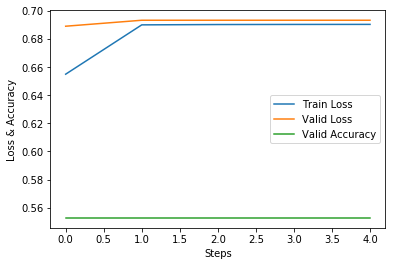

In [345]:

# 绘制误差曲线
a = [i[0] for i in records]
b = [i[1] for i in records]
c = [i[2] for i in records]
plt.plot(a, label = 'Train Loss')
plt.plot(b, label = 'Valid Loss')
plt.plot(c, label = 'Valid Accuracy')
plt.xlabel('Steps')
plt.ylabel('Loss & Accuracy')
plt.legend()

In [346]:
#在测试集上分批运行，并计算总的正确率
vals = [] #记录准确率所用列表

#对测试数据集进行循环
for data, target in zip(test_data, test_label):
    data, target = torch.tensor(data, dtype = torch.float).view(1,-1), torch.tensor(np.array([target]), dtype = torch.long)
    output = model(data) #将特征数据喂入网络，得到分类的输出
    val = rightness(output, target) #获得正确样本数以及总样本数
    vals.append(val) #记录结果

#计算准确率
rights = (sum([tup[0] for tup in vals]), sum([tup[1] for tup in vals]))
right_rate = 1.0 * rights[0].data.numpy() / rights[1]
right_rate

/anaconda3/lib/python3.6/site-packages/torch/nn/modules/container.py:100: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0.5376884422110553